# Creating a Simpler Model
> Creating a simple model without any "machine learning".

- toc:true
- branch: master
- badges: true
- comments: true
- author: Juan Cruz Alric
- categories: [deep-learning, jupyter, fastai]

In [1]:
# This will automatically install any dependency that you dont have in 
# your machine to run the code
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

voila 0.2.3 has requirement nbconvert<7,>=6.0.0, but you'll have nbconvert 5.6.1 which is incompatible.


/home/juancruzalric/.pyenv/versions/3.7.4/envs/fastai/lib/python3.7/site-packages/fastbook/__init__.py:22: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
from fastai.vision.all import *
from fastbook import *

# We are going to work with grey scale images
matplotlib.rc('image', cmap='Greys')

## Mnist Dataset

Mnist Dataset contains a lot of images from 0 to 9. We are going to try and classify any image as a 3 or a 7

In [10]:
URLs.MNIST_SAMPLE

'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

In [11]:
path = untar_data(URLs.MNIST_SAMPLE)

In [12]:
path

Path('/home/juancruzalric/.fastai/data/mnist_sample')

In [13]:
path.ls()

(#3) [Path('/home/juancruzalric/.fastai/data/mnist_sample/train'),Path('/home/juancruzalric/.fastai/data/mnist_sample/valid'),Path('/home/juancruzalric/.fastai/data/mnist_sample/labels.csv')]

ls() ---> is a method created by fastai. It let you see what is inside the directory. It will return a object called by "L". It has the same functionality as a "list" in python.

We can also see that we have a train directory and a valid directory

In [14]:
(path/'train').ls()

(#2) [Path('/home/juancruzalric/.fastai/data/mnist_sample/train/3'),Path('/home/juancruzalric/.fastai/data/mnist_sample/train/7')]

There are two directories inside "/train" one is "/train/7" and the other one is "/train/3". The "/3" and "/7" represents the labels of the data

In [15]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/home/juancruzalric/.fastai/data/mnist_sample/train/3/10.png'),Path('/home/juancruzalric/.fastai/data/mnist_sample/train/3/10000.png'),Path('/home/juancruzalric/.fastai/data/mnist_sample/train/3/10011.png'),Path('/home/juancruzalric/.fastai/data/mnist_sample/train/3/10031.png'),Path('/home/juancruzalric/.fastai/data/mnist_sample/train/3/10034.png'),Path('/home/juancruzalric/.fastai/data/mnist_sample/train/3/10042.png'),Path('/home/juancruzalric/.fastai/data/mnist_sample/train/3/10052.png'),Path('/home/juancruzalric/.fastai/data/mnist_sample/train/3/1007.png'),Path('/home/juancruzalric/.fastai/data/mnist_sample/train/3/10074.png'),Path('/home/juancruzalric/.fastai/data/mnist_sample/train/3/10091.png')...]

Lets try and print out one of the images

In [16]:
img3_path = threes[1]
im3 = Image.open(img3_path)
im3

In [17]:
img7_path = sevens[1]
im7 = Image.open(img7_path)
im7

But sadly... a computer only undestands numbers we will need to transform this images

In [19]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

We are printing rows from 4 up to 10 (not including 10) and columns 4 to 10 (not including 10)

We can see it more clearly using a Dataframe (Pandas library).

In [20]:
type(array(im3))

numpy.ndarray

In [21]:
type(tensor(im3))

torch.Tensor

tensors and numpy arrays are similar. However tensors let you run your operations in the GPU making your work process faster. We are going to use tensors from now on.

In [30]:
img3_t = tensor(im3)
df = pd.DataFrame(img3_t[4:22, 4:22])
## Just setting the font-size and a background color as Grey with some gradient to see the 
## density of the pixels
df.style.set_properties(**{'font-size':'10pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


### Creating a SIMPLE Model

We are going to create a simple model that takes the AVG (averages) of each class to predict and use that to check if a new image pixels are near the average of the 3 or the 7.

In [31]:
seven_tensors = [tensor(Image.open(path)) for path in sevens]
three_tensors = [tensor(Image.open(path)) for path in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

This is getting each path for the corresponding images and transforming them into a tensor, however all those tensors are inside a list

In [35]:
type(seven_tensors)

list

In [34]:
type(seven_tensors[0])

torch.Tensor

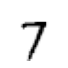

In [36]:
show_image(seven_tensors[5]);

show_image() is going to transform those tensors into a image because each value inside the tensor represent a pixel

We would like to compute the avg of the density of each pixel. We will neet to stack each image and create a 3 dimencional tensor, which the hight is going to be the amount of images, and the other 2 dimensions are going to be 28x28 pixels size. We can use the stack method given us by pytorch.

In [37]:
stacked_sevens = torch.stack(seven_tensors).float() / 255
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_threes.shape

torch.Size([6131, 28, 28])

we can also check the dimensions by calling ndim

In [46]:
stacked_threes.ndim

3

<AxesSubplot:>

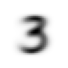

In [48]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

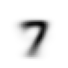

In [52]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

Now we have the ideal digits for 3 and 7.
Let us pick an arbitrary 3 and measure its distance to the ideal one.
We are going to explain two different ways
- Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or *L1 norm*
- Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the *root mean squared error* (RMSE) or *L2 norm*.

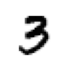

In [53]:
a_3 = stacked_threes[3]
show_image(a_3);

In [55]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1154), tensor(0.2064))

In [56]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1669), tensor(0.3170))

 We can see that the distance betweem the 3 and the "ideal" 3 is shorter than the "ideal" 7
 pytorch already provides both of these as loss functions

In [58]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1669), tensor(0.3170))

The mean_square_error will penalize bigger mistakes more heavily and be more lenient with small mistakes

### Metric

A metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is.
Remeber that the Mnist dataset already has a directory called "Valid". This directory contains the data where we are going to calculate how well our model operates.

We are going to use the 'stack' pytorch operation to stack all the images contain in de valid directory

In [59]:
valid_3_tens = torch.stack([tensor(Image.open(path)) 
                            for path in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(path)) 
                            for path in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Here we see two tensors, one representing the 3s validation set of 1,010 images of size 28×28, and one representing the 7s validation set of 1,028 images of size 28×28.

We can write a simple function that calculates the mean absolute error using an experssion very similar to the one we wrote in the last section:

In [60]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

In [61]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1605, 0.1107, 0.1181,  ..., 0.1419, 0.1103, 0.1162]),
 torch.Size([1010]))

We can use mnist_distance to figure out whether an image is a 3 or not by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

In [62]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

Let's test it with one of our examples

In [63]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [64]:
is_3(valid_3_tens)

tensor([False,  True,  True,  ...,  True,  True,  True])

Now we can calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:

In [65]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1- is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

We're getting over 90% accuracy on both 3s and 7s, and we've seen how to define a metric conveniently using broadcasting.

However: 3s and 7s are very different-looking digits. And we're only classifying 2 out of the 10 possible digits so far. So we're going to need to do better!

But now we know a simpler model that can predict with a 95% accuracy and if we create a deep learning model that predict with 94% accuracy we can clearly see that is not a good model and we will need to try other things.